9.4 2장에서 제시된 물가상승률의 표본기간을 확장한 다음, 구조변화가 2번인 모형을 추정하고 그 결과를 제시하시오

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats.mstats import winsorize

In [2]:
data_path='./data/korea_cpi_crude_oil.csv'
data = pd.read_csv(data_path, index_col=0, parse_dates=True)

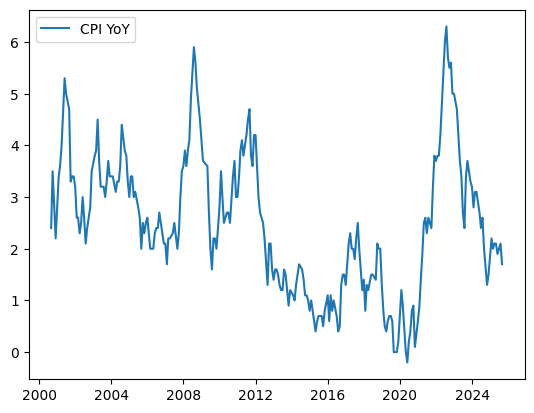

In [3]:
import matplotlib.pyplot as plt
plt.plot(data.index, data['korea_cpi_yoy'], label='CPI YoY')
plt.legend()
plt.show()

In [4]:
y=data['korea_cpi_yoy'].iloc[1:]
x=data['korea_cpi_yoy'].shift(1).iloc[1:].to_frame()
x['const']=1
x.dropna(inplace=True)
print(x.head())

            korea_cpi_yoy  const
2000-09-30            2.4      1
2000-11-30            3.5      1
2000-12-31            2.2      1
2001-01-31            2.8      1
2001-02-28            3.4      1


2 State Model

In [9]:
from scipy.stats import invgamma, multivariate_normal, norm, beta

def sampling_beta(y:pd.Series, x:pd.DataFrame, state: pd.Series, sigma_list: list, beta_prior_mean: np.ndarray, beta_prior_var: np.ndarray):
    state_value_list=sorted(np.unique(state.values).tolist())
    y_list=[]
    x_list=[]
    for s in state_value_list:
        y_list.append(y.loc[state[state==s].index])
        x_list.append(x.loc[state[state==s].index])

    beta_var_inv=np.linalg.pinv(beta_prior_var)

    beta_sample_list=[]
    for i, s in enumerate(state_value_list):
        beta_post_var=np.linalg.pinv(beta_var_inv + (x_list[i].T @ x_list[i])/sigma_list[i])
        beta_post_mean=beta_post_var @ (beta_var_inv @ beta_prior_mean + (x_list[i].T @ y_list[i])/sigma_list[i])
        beta_sample=multivariate_normal.rvs(mean=beta_post_mean, cov=beta_post_var)
        beta_sample_list.append(beta_sample)

    return beta_sample_list, y_list, x_list

def sampling_sigma2(y_list:list, x_list:list, beta_list:list, alpha_prior:float, beta_prior:float):
    sigma2_list=[]
    for i in range(len(y_list)):
        res=y_list[i] - x_list[i] @ beta_list[i]

        # sampling sigma2
        shape=(alpha_prior + len(res))/2
        scale=(beta_prior + res.T @ res)/2
        sigma2=invgamma.rvs(a=shape, scale=scale)

        sigma2_list.append(sigma2)
    return sigma2_list

def sampling_state(y:pd.Series, x:pd.DataFrame, beta_list:list, sigma_list:list, p_list:list):
    '''
    y: dependent variable
    x: independent variable
    beta_list: list of beta for each state
    sigma_list: list of sigma2 for each state
    p_list: list of transition probabilities [p_state_k_to_k,...]
    '''
    def get_filtered_prob(y:pd.Series, x:pd.DataFrame, beta_list:list, sigma_list:list, p_list:list):
        # get filtered probability by hamilton filter
        
        # initial state probability
        prob=np.zeros((len(p_list), len(p_list)))
        for i in range(len(p_list)):
            prob[i, i]=p_list[i]
            if i < len(p_list)-1:
                prob[i, i+1]=1-p_list[i]

        prob_init=np.zeros(len(p_list))
        if p_list[-1] <1:
            # steady state probability
            e_vals, e_vecs=np.linalg.eig(prob.T)
            stat_dist=e_vecs[:, np.isclose(e_vals, 1)]
            stat_dist=np.real(stat_dist[:,0]/np.sum(stat_dist[:,0]))
            prob_init=stat_dist
        else:
            prob_init[0]=1.0

        filtered_prob=pd.DataFrame(0.0, index=y.index, columns=range(1, len(p_list)+1))
        filtered_prob.iloc[0, :]=prob_init
        for t in range(1, len(y)):
            y_t=y.iloc[t]
            x_t=x.iloc[t, :]

            # predicted probability P(S_t=j|Y_{t-1}, \theta
            pred_prob=np.zeros(len(p_list))
            for j in range(len(p_list)):
                pred_prob[j]=np.sum(filtered_prob.iloc[t-1, :] * prob[:, j])
            # likelihood P(y_t |Y_{t-1}, \theta)
            like_prob=np.zeros(len(p_list))
            for j in range(len(p_list)):
                like_prob[j]=norm.pdf(y_t, loc=x_t @ beta_list[j], scale=np.sqrt(sigma_list[j]))

            # update filtered probability
            filtered_prob.iloc[t, :] = pred_prob * like_prob
            filtered_prob.iloc[t, :] /= filtered_prob.iloc[t, :].sum()

        return filtered_prob, prob
    
    def backward_sampling(filtered_prob:pd.DataFrame, prob_matrix:np.ndarray):
        # backward sampling using the filtered probability and transition probability matrix
        state = np.zeros(len(filtered_prob), dtype=int)
        for t in range(len(filtered_prob)-1, 0, -1):
            if t == len(filtered_prob)-1:
                state[t] = np.random.choice(range(1, len(prob_matrix)+1), p=filtered_prob.iloc[t, :])
            else:
                before_state = state[t+1]
                cur_p=np.zeros(len(p_list))
                for j in range(len(p_list)):
                    cur_p[j]=filtered_prob.iloc[t, j]*prob_matrix[j, before_state-1]
                cur_p=cur_p/cur_p.sum()
                state[t] = np.random.choice(range(1, len(p_list)+1), p=cur_p)
        state[0]=1
        return state

    filtered_prob, prob_matrix=get_filtered_prob(y, x, beta_list, sigma_list, p_list)

    state = backward_sampling(filtered_prob, prob_matrix)

    return state

def sampling_transition_prob(post_state, alpha_prior, beta_prior, state_cnt=None):
    def count_transition(states, state_cnt=None):
        if state_cnt is not None:
            k=state_cnt
        else:
            k = int(np.max(states))  # 상태 개수 자동 추정
        count = np.zeros((k, k))
        for t in range(1, len(states)):
            count[states[t-1]-1, states[t]-1] += 1
        return count

    transition_count=count_transition(post_state, state_cnt=state_cnt)
    p=np.zeros(transition_count.shape[0])
    for i in range(transition_count.shape[0]):
        a_post=alpha_prior + transition_count[i, i]
        b_post=beta_prior + np.sum(transition_count[i, :]) - transition_count[i, i]
        p[i]=beta.rvs(a=a_post, b=b_post)
    return p

    

In [ ]:
# set prior hyperparameters

# beta_prior
beta_mu=[0.7, 0.5]
beta_sigma=np.diag([0.01, 0.09])

# sigma prior (3 states)
sigma_a=10
sigma_b=1
sigma2_beta_list=[0.5*sigma_b/(0.5*sigma_a-1) for _ in range(3)]

# state prior
p1_a=200
p1_b=5
states_prior=pd.Series(np.ones(len(y)), index=y.index)
states_prior.iloc[int(len(y)/3):int(2*len(y)/3)]=2
states_prior.iloc[int(2*len(y)/3):]=3
p_list=[(p1_a)/(p1_a+p1_b), (p1_a)/(p1_a+p1_b), 1.0]

# sampling results
burn_in=1000
n_samples=5000
total_samples=burn_in+n_samples
state_samples=pd.DataFrame(np.zeros((total_samples, len(y))), columns=y.index)
change_points_cnt=pd.Series(np.zeros(len(y)), index=y.index)
beta_sample_list=[pd.DataFrame(np.zeros((total_samples, 2)), columns=['korea_cpi_yoy', 'const']) for _ in range(3)]
sigma2_samples_list=[pd.Series(np.zeros(total_samples)) for _ in range(3)]
p_samples_list=pd.DataFrame(np.zeros((total_samples, len(p_list)-1)), columns=[f'p{i+1}{i+1}' for i in range(len(p_list)-1)]) # 구조 변화 모형이므로 p_lastlast=1.0

for i in tqdm(range(total_samples)):
    # step 1: sample beta1, beta2
    beta_samples, y_list, x_list = sampling_beta(y, x, states_prior, sigma2_beta_list, np.array(beta_mu), beta_sigma)
    for j in range(len(beta_samples)):
        beta_sample_list[j].iloc[i, :]=beta_samples[j]

    # step 2: sample sigma2_1, sigma2_2
    sigma2_list=sampling_sigma2(y_list, x_list, beta_samples, sigma_a, sigma_b)
    for j in range(len(sigma2_list)):
        sigma2_samples_list[j].iloc[i]=sigma2_list[j]

    # step 3: sample states
    states_post=sampling_state(y, x, beta_samples, sigma2_list, p_list)
    states_prior=pd.Series(states_post, index=y.index)
    state_samples.iloc[i, :]=states_post

    if i > burn_in:
        change_points_cnt+=states_prior.diff().fillna(0).abs().values

    # step 4: sample transition probability
    new_p_list=sampling_transition_prob(states_post, p1_a, p1_b)
    p_list=np.append(new_p_list[:-1], [1.0]) # 마지막 상태는 자기 자신으로만전이
    p_samples_list.iloc[i]=p_list[:-1]

100%|██████████| 600/600 [01:06<00:00,  9.00it/s]


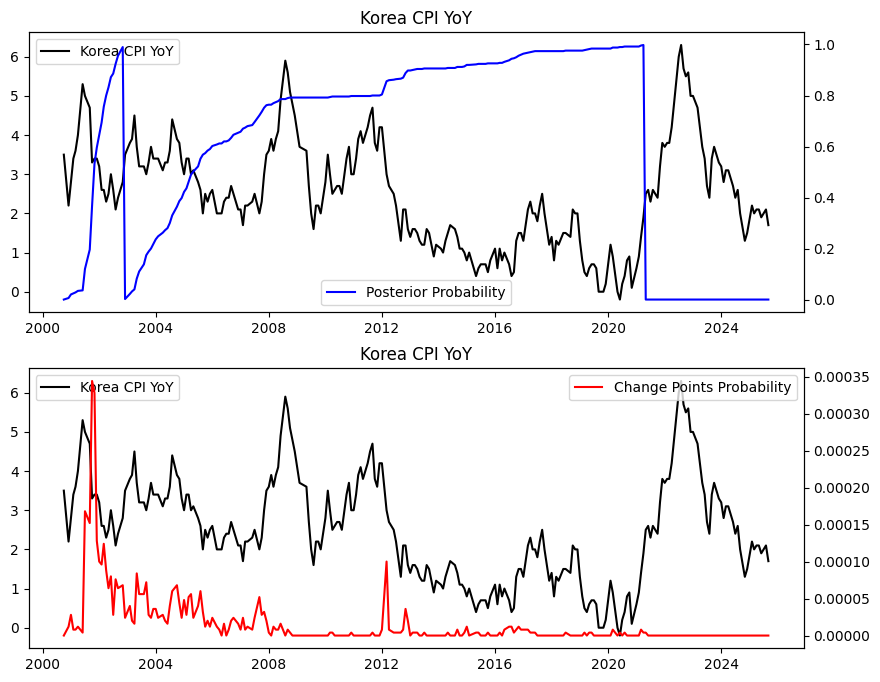

In [16]:
import matplotlib.pyplot as plt

change_points_cnt=change_points_cnt/(n_samples)

fig, axes=plt.subplots(2, 1, figsize=(10, 8))
axes[0].plot(y.index, y, label='Korea CPI YoY', color='black')
axes[0].set_title('Korea CPI YoY')
axes[0].legend()
ax2=axes[0].twinx()
post_states=state_samples.iloc[burn_in:, :]
post_prob=post_states.mean()-post_states.mean().astype(int)
ax2.plot(y.index, post_prob, label='Posterior Probability', color='blue')
ax2.legend()
axes[1].plot(y.index, y, label='Korea CPI YoY', color='black')
axes[1].set_title('Korea CPI YoY')
axes[1].legend()
ax3=axes[1].twinx()
ax3.plot(y.index, change_points_cnt, label='Change Points Probability', color='red')
ax3.legend()
plt.show()

In [19]:
for i in range(len(beta_sample_list)):
    print(f'Beta {i+1} mean:\n', beta_sample_list[i].iloc[burn_in:, :].mean(), f'Beta {i+1} std:\n', beta_sample_list[i].iloc[burn_in:, :].std())
    print(f'Sigma2 {i+1} mean:', sigma2_samples_list[i].iloc[burn_in:].mean(), f'Sigma2 {i+1} std:', sigma2_samples_list[i].iloc[burn_in:].std())

Beta 1 mean:
 korea_cpi_yoy    0.776143
const            0.862484
dtype: float64 Beta 1 std:
 korea_cpi_yoy    0.063315
const            0.230844
dtype: float64
Sigma2 1 mean: 0.29991873666862284 Sigma2 1 std: 0.11615810915025816
Beta 2 mean:
 korea_cpi_yoy    0.731884
const            0.633038
dtype: float64 Beta 2 std:
 korea_cpi_yoy    0.081884
const            0.254092
dtype: float64
Sigma2 2 mean: 0.12557910140615533 Sigma2 2 std: 0.05283290120159885
Beta 3 mean:
 korea_cpi_yoy    0.940093
const            0.140034
dtype: float64 Beta 3 std:
 korea_cpi_yoy    0.017557
const            0.049912
dtype: float64
Sigma2 3 mean: 0.17334647104460144 Sigma2 3 std: 0.01928183669079188
